In [7]:
from utils import add_syn_mut_attribute, add_mut_accumulation_attr, final_pos_genotype, get_parent
from utils_convergence import count_independent_occurrences
from utils_randomization import get_branch_lengths, randomize_one_mut_on_tree_multinomial
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy import stats
import matplotlib.gridspec as gridspec
from collections import Counter
import requests
import json

## Figure 5: Clades with the 3-amino acid deletion in Nsp6 have a higher number of S1 mutations

##### Calculating the average number of S1 substitutions in clades with versus without a convergently-evolved mutation shows that ORF1a:3675-3677del clades have more S1 substitutions

#### This notebook completes the analyses for Figures 5 A and Figure 5 Supplement 1. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Add information about synonymous mutations as an attribute of nodes on the tree

In [3]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that gives the total number of mutations accumulated between the tree root and that node (including mutations on the node). 

In [4]:
tree = add_mut_accumulation_attr(tree)

For each node on the tree, check whether it has the genotype of the convergently-evolved mutations (mutation could have occurred at this node or in a parent, as long as it didn't mutate again). Store this information and S1 and RdRp accumulation numbers in a dataframe

In [5]:
# list of tuples describing the convergently-evolved mutations to consider
# format is (gene, position, genotype_of_interest)
muts_to_consider = [('ORF1a', 3676, '-'), ('ORF1a', 3255, 'I'), ('ORF1a', 3606, 'F'), 
                    ('N', 205, 'I'), ('N', 194, 'L'), ('N', 234, 'I'), ('M', 82, 'T'), 
                    ('S', 501, 'Y'), ('S', 484, 'K'), ('S', 452, 'R')]

In [8]:
to_plot = []

for node in tree.find_clades(terminal=False):
    
    if len(node.get_terminals()) >=15:
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']

        s1_mutations = node.node_attrs["s1_accumulation"]
        rdrp_mutations =  node.node_attrs["rdrp_accumulation"]
        date = node.node_attrs["num_date"]["value"]

        # Find all parents of the node
        parents = get_parent(tree, node)
        
        # initialize dictionary to keep track of whether node has each of the mutations being considered
        node_muts = {}
        
        # consider each mutation
        for m in muts_to_consider:
            # Make a list of mutations that occur at this site in parents of the node (and at node)
            parent_muts_at_site = []
            for parent in parents:
                if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
                    #find specific mutations of interest
                    if m[0] in parent.branch_attrs["mutations"]:
                        for mut in parent.branch_attrs["mutations"][m[0]]:
                            if int(mut[1:-1])==m[1]:
                                parent_muts_at_site+=[mut]
                            
            # find whether the genotype at this position is the mutation being considered
            mut_at_site = final_pos_genotype(parent_muts_at_site, m[2])
            node_muts[f'{m[0]}:{m[1]}{m[2]}'] = mut_at_site
            
        to_plot.append({**{'clade': node.name, 's1_mutations': s1_mutations, 
                           'rdrp_mutations':rdrp_mutations,'emerging_lineage': emerging_lineage, 
                           'date': date}, 
                        **node_muts})

to_plot_df = pd.DataFrame(to_plot)

Find the earliest occurrence of each mutation

In [9]:
#find earliest occurrence of each mutation and limit dataset to that
earliest_muts = {('ORF1a','G3676-'): 2022, ('ORF1a','T3255I'): 2022, 
                 ('ORF1a','L3606F'): 2022, ('N', 'T205I'): 2022, 
                 ('N', 'S194L'):2022, ('N', 'M234I'):2022, ('M', 'I82T'):2022, 
                 ('S', 'N501Y'):2022,('S', 'E484K'):2022, ('S', 'L452R'):2022}


for gene, mut in earliest_muts.keys():
    
    for node in tree.find_clades(terminal=False):
        if hasattr(node, "branch_attrs") and "mutations" in parent.branch_attrs:
            if gene in node.branch_attrs["mutations"]:
                if mut in node.branch_attrs["mutations"][gene]:
                    date = node.node_attrs["num_date"]["value"]
                    if date < earliest_muts[(gene, mut)]:
                        earliest_muts[(gene, mut)] = date


Now, restructure datafame to have a column for s1 and rdrp mutation mean with and without each subsitution. The data will be limited to after the first occurrence of this substitution

In [10]:
with_and_without_muts = []

for gene, mut in earliest_muts.keys():
    earliest_date = earliest_muts[(gene, mut)]
    date_subset_df = to_plot_df[to_plot_df['date']>=earliest_date]
    
    to_plot_column = f'{gene}:{mut[1:-1]}{mut[-1]}'
    
    mut_s1 = list(date_subset_df[date_subset_df[to_plot_column]==True]['s1_mutations'])
    nomut_s1 = list(date_subset_df[date_subset_df[to_plot_column]==False]['s1_mutations'])
    
    mut_rdrp = list(date_subset_df[date_subset_df[to_plot_column]==True]['rdrp_mutations'])
    nomut_rdrp = list(date_subset_df[date_subset_df[to_plot_column]==False]['rdrp_mutations'])
    
    # for S1 mutations, don't count themselves as an S1 mutation
    # for the convergent S1 mutations, need to subtract 1 from the S1 count 
    # of all clades that where 'has_mutation'==True
    if gene=='S':
        fix_count = 1
    else:
        fix_count = 0
    
    for d1 in mut_s1:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': True, 's1_mutations': d1-fix_count})
    for d2 in nomut_s1:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': False, 's1_mutations': d2})
    for d3 in mut_rdrp:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': True, 'rdrp_mutations': d3})
    for d4 in nomut_rdrp:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': False, 'rdrp_mutations': d4})
    
with_and_without_muts_df = pd.DataFrame(with_and_without_muts)

Plot the number of S1 and RdRp substitutions in clades that do and do not have each of these mutations.

This is Figure 5 Supplement 1

In [11]:
def fig5_supp(filename=None):
    cmap1 = {False:"#ABABAB",True:"#4770eb"}
    cmap2 = {False:"#ABABAB",True:"#ff8c3a"}

    f = plt.figure(figsize=(10,10))

    gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])


    ax1 = sns.pointplot(x='mutation', y='s1_mutations', 
                      hue = 'has_mutation', palette=cmap1,
                      dodge = 0.25, join=False, ci='sd', scale=2.0,errwidth=1.5, capsize=0.05,
                      data=with_and_without_muts_df, ax=ax1)

    ax2 = sns.pointplot(x='mutation', y='rdrp_mutations', 
                      hue = 'has_mutation', palette=cmap2,
                      dodge = 0.25, join=False, ci='sd', scale=2.0, errwidth=1.5, capsize=0.05,
                      data=with_and_without_muts_df, ax=ax2)


    ax1.set_xlabel('', fontsize = 14)
    ax1.set_ylabel('Number of S1 mutations', fontsize = 14)
    ax2.set_xlabel('', fontsize = 14)
    ax2.set_ylabel('Number of RdRp mutations', fontsize = 14)
    ax2.set_ylim(0,4)
    ax2.set_yticks([0,2,4])
    sns.despine(left=False, bottom=False)

    handles1, labels1 = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles1, labels1, title='Has Mutation')

    handles2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles2, labels2, title='Has Mutation')

    _, xlabels = plt.xticks()
    xlabels[0] = 'ORFa1_3675-3677del'
    ax1.set_xticklabels('', size = 8, rotation=20)
    ax2.set_xticklabels(xlabels, size = 12, rotation=30)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


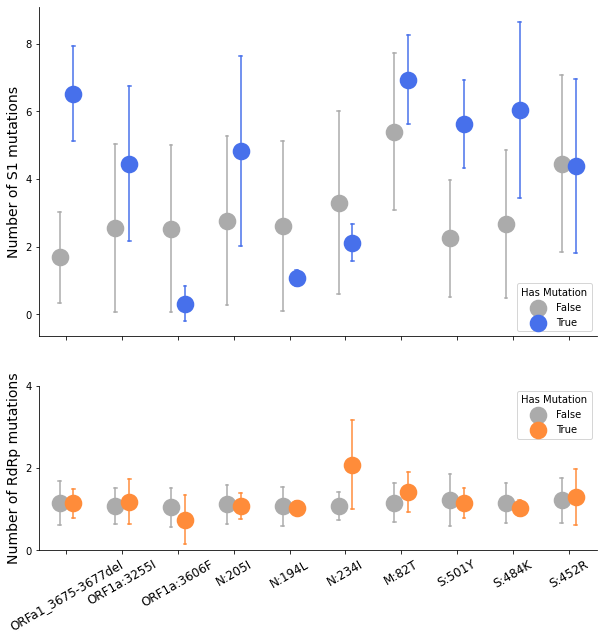

In [12]:
fig5_supp()

The biggest difference between S1 mutation count with/without a convergently-evolved mutation is for ORF1a:3675-3677del. To test whether this difference is expected for a mutation that occurs as many times as this deletion does, randomize the position of this mutation on the tree

In [13]:
all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(tree)
# reformat the names of the mutations
independent_occurrences_all_mutations = {(k.split(':')[0]+':'+k.split(':')[1][1:]):v for 
                                         k,v in independent_occurrences_all_mutations.items()}

In [14]:
def randomize_one_mut_on_tree_multinomial(tree, num_occurrences):
    """
    Given the number of times a mutation occurs on the phylogeny, 
    randomly throw it on the phylogeny using a multinomial draw. 
    Return a list of branches with this mutation or return 
    "bad_randomization" if the mutation occurs twice on the same path
    """
    
    branch_names, branch_lengths = get_branch_lengths(tree, num_tips=15)
    
    # multinomial draw to randomize mutations on tree
    branch_lengths_normalized = [x/sum(branch_lengths) for x in branch_lengths]

    hits = list(np.random.multinomial(num_occurrences, branch_lengths_normalized, size=1))[0]

    branchs_with_mut = dict(zip(branch_names, hits))
    branchs_with_mut_list = [k for k,v in branchs_with_mut.items() if v!=0]
    
    parents_of_all_hits = []

    for node in tree.find_clades():
        if node.name in branchs_with_mut_list:
            parents = get_parent(tree, node)[:-1]
            parent_names= [p.name for p in parents]
            parents_of_all_hits+=parent_names
            
    for node in tree.find_clades():
        if node.name in branchs_with_mut_list:
            if node.name in parents_of_all_hits:
                branchs_with_mut_list = 'bad_randomization'

    return branchs_with_mut_list

In [15]:
def s1_muts_after_random(tree, random_branch_list, mutation):
    """
    Given a list of branches that have the randomized mutation, 
    find the number of S1 mutations that occur in clades that 
    do or do not have the random mutation.
    
    Return a dataframe with the number of S1 and RdRp mutation a clade 
    has and whether or not it has the randomized mutation
    """
    
    random_to_plot = []

    for node in tree.find_clades(terminal=False):

        if len(node.get_terminals()) >=15:

            s1_mutations = node.node_attrs["s1_accumulation"]
            rdrp_mutations =  node.node_attrs["rdrp_accumulation"]
            date = node.node_attrs["num_date"]["value"]


            #Find all parents of the node
            parents = get_parent(tree, node)

            # if parent is one of the randomly chosen branches that has a mutation
            if len(parents)>0:
                for parent in parents:
                    if parent.name in random_branch_list:
                        has_random_mutation = True
                    else:
                        has_random_mutation = False


                random_to_plot.append({'clade': node.name,
                                       'mutation': f'{mutation}_expected',
                                       'has_mutation': has_random_mutation,
                                       's1_mutations': s1_mutations, 
                                       'rdrp_mutations':rdrp_mutations, 
                                       'date': date})

    
    return random_to_plot

In [18]:
def expected_s1muts_on_randomized_tree(tree,independent_occurrences, mut, iterations, save_filename):
    """
    Randomization the position of "mut" on the tree X=iterations times.
    Find the number of S1 mutations in clades that do or do 
    not have the randomized mutation
    """
    
    # find the number of times this mutation occurs on phylogeny
    num_occurrences = independent_occurrences[mut]
    
    mut_s1_stats_dict = {'mutation_s1_stats':[]}
    
    # run randomizations until there are x='iterations' successful ones
    x=0
    while x<iterations:
        branchs_with_mut_list = randomize_one_mut_on_tree_multinomial(tree, num_occurrences)

        if branchs_with_mut_list=='bad_randomization':
            pass

        else:
            x+=1
            random_to_plot = s1_muts_after_random(tree, branchs_with_mut_list, mut)
            for y in random_to_plot:
                mut_s1_stats_dict['mutation_s1_stats'].append(y)

            
    with open(save_filename, 'w') as outfile:
        json.dump(mut_s1_stats_dict, outfile)

In [27]:
expected_s1muts_on_randomized_tree(tree,independent_occurrences_all_mutations, 
                                   'ORF1a:3675-', 100, 'randomized_mut_s1_stats/randomized_3676-_s1_100its.json')

The function makes Figure 5A.

In [25]:
def fig5a(empirical_df, data_files, filename=False):
    """
    Plot the number of S1 or RdRp mutations in clades that 
    do or do not have ORF1a:3675-3677del. Compare empirical 
    data to data from randomized trees 
    """

    # initialize dataframe to store information from all .json files where data is stored
    randomized_df = pd.DataFrame(columns = ['clade', 'mutation', 'has_mutation', 
                                            's1_muations', 'rdrp_mutations', 'date'])
    
    # read data from all randomizations
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            temp_df = pd.DataFrame(data['mutation_s1_stats'])
            randomized_df = pd.concat([randomized_df, temp_df])
            
    randomized_df = randomized_df.drop(columns=['clade', 'date'])
    empirical_df = empirical_df[empirical_df['mutation']=='ORF1a:3676-']
    # merge randomized and empirical data into one dataframe
    compare_to_random_df = pd.concat([randomized_df, empirical_df], ignore_index=True)
    
    cmap1 = {False:"#ABABAB",True:"#4770eb"}
    cmap2 = {False:"#ABABAB",True:"#ff8c3a"}

    f = plt.figure(figsize=(6,8))
    sns.set_style('white')

    gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])


    ax1 = sns.pointplot(x='mutation', y='s1_mutations', 
                      hue = 'has_mutation', palette=cmap1,
                      dodge = 0.25, join=False, ci='sd', scale=1.5,errwidth=1.5, 
                        capsize=0,
                      data=compare_to_random_df, ax=ax1)

    ax2 = sns.pointplot(x='mutation', y='rdrp_mutations', 
                        hue = 'has_mutation', palette=cmap2,
                        dodge = 0.25, join=False, ci='sd', scale=1.5, errwidth=1.5, 
                        capsize=0,
                      data=compare_to_random_df, ax=ax2)


    ax1.set_xlabel('', fontsize = 14)
    ax1.set_ylabel('Number of S1 mutations', fontsize = 12)
    ax2.set_xlabel('', fontsize = 14)
    ax2.set_ylabel('Number of RdRp mutations', fontsize = 12)
    ax2.set_ylim(0,4)
    ax2.set_yticks([0,2,4])
    sns.despine(left=False, bottom=False)

    handles1, labels1 = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles1, labels1, loc='lower right', title='ORF1a:3675-3677del', bbox_to_anchor=(1.1,0))

    handles2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles2, labels2, title='ORF1a:3675-3677del', bbox_to_anchor=(1.1,1.0))

    _, xlabels = plt.xticks()
    xlabels[0] = 'expected'
    xlabels[1] = 'observed'
    ax1.set_xticklabels('', size = 8, rotation=20)
    ax2.set_xticklabels(xlabels, size = 12, rotation=30)
    
#     ax1.set_title('Clades with ORF1a:3675-3677 deletion', size=14)

    plt.figtext(0.04, 0.88, 'A', fontsize=24, fontweight='bold')

    if filename:
        f.savefig(filename, dpi=300, bbox_inches='tight')


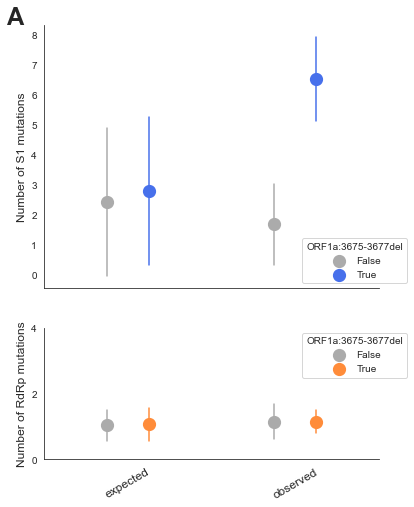

In [28]:
fig5a(with_and_without_muts_df, ['randomized_mut_s1_stats/randomized_3676-_s1_100its.json'], 
      filename='plots/fig5a_20210515.png')